# 유방암 종양 예측
---
## 악성 종양인지, 양성 종양(정상)인지 예측

## 데이터셋 불러오기

* radius : 반경
* texture : 질감
* perimeter : 둘레
* area : 면적
* smoothness : 매끄러움
* compactness : 조그만 정도
* concavity : 윤곽의 오목함
* concave points : 윤곽의 오목한 부분의 수
* symmetry : 대칭
* fractal dimension : 프랙탈 차원
* target : Malignant-악성 종양 / Benign-양성 종양(정상)
---
* mean ~ : 데이터별 평균 값
* ~ error : 데이터별 표준편차 값
* worst ~ : 데이터별 가장 큰 3개의 평균으로 만든 값

In [1]:
import pandas as pd
import numpy as np

In [3]:
data = pd.read_csv('https://raw.githubusercontent.com/DrKAI/dataset/main/breast_cancer.csv')

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   mean radius              569 non-null    float64
 1   mean texture             569 non-null    float64
 2   mean perimeter           569 non-null    float64
 3   mean area                569 non-null    float64
 4   mean smoothness          569 non-null    float64
 5   mean compactness         569 non-null    float64
 6   mean concavity           569 non-null    float64
 7   mean concave points      569 non-null    float64
 8   mean symmetry            569 non-null    float64
 9   mean fractal dimension   569 non-null    float64
 10  radius error             569 non-null    float64
 11  texture error            569 non-null    float64
 12  perimeter error          569 non-null    float64
 13  area error               569 non-null    float64
 14  smoothness error         5

## 데이터 전처리

<details><summary>Hint</summary>

* x, y 구분 필요
* y에 대한 전처리 필요
* 데이터셋 구분 필요

</details>

In [11]:
#악성 종양 여부가 더 중요한 것이라 Malignant를 1로 설정
data.loc[data["target"] == "Malignant", "target"] = 1
data.loc[data["target"] == "Benign", "target"] = 0

data["target"] = data["target"].astype(float)

In [12]:
x = data.drop("target", axis = 1)
y = data.loc[:, "target"]

In [13]:
x.shape, y.shape

((569, 30), (569,))

In [14]:
from sklearn.model_selection import train_test_split
train_x, test_x, train_y, test_y = train_test_split(x, y, test_size = 0.1, random_state = 2022)
train_x.shape, train_y.shape

((512, 30), (512,))

In [15]:
train_x.columns

Index(['mean radius', 'mean texture', 'mean perimeter', 'mean area',
       'mean smoothness', 'mean compactness', 'mean concavity',
       'mean concave points', 'mean symmetry', 'mean fractal dimension',
       'radius error', 'texture error', 'perimeter error', 'area error',
       'smoothness error', 'compactness error', 'concavity error',
       'concave points error', 'symmetry error', 'fractal dimension error',
       'worst radius', 'worst texture', 'worst perimeter', 'worst area',
       'worst smoothness', 'worst compactness', 'worst concavity',
       'worst concave points', 'worst symmetry', 'worst fractal dimension'],
      dtype='object')

## Locally connected layer를 구성하기 위한 feature 설정

* mean, error, worst를 각 feature별로 묶어 새로운 변수를 만든다.
        ex) mean radius, radius error, worst radius

<details><summary> Hint </summary>

* x의 train 구조와 test 구조는 동일해야 한다.

</details>

In [16]:
tr_radius = train_x.loc[:, ["mean radius", "radius error", "worst radius"]]
tr_texture = train_x.loc[:, ["mean texture", "texture error", "worst texture"]]
tr_area = train_x.loc[:, ["mean area", "area error", "worst area"]]
tr_perimeter = train_x.loc[:, ["mean perimeter", "perimeter error", "worst perimeter"]]
tr_smoothness = train_x.loc[:, ["mean smoothness", "smoothness error", "worst smoothness"]]
tr_compactness = train_x.loc[:, ["mean compactness", "compactness error", "worst compactness"]]
tr_concavity = train_x.loc[:, ["mean concavity", "concavity error", "worst concavity"]]
tr_con_point = train_x.loc[:, ["mean concave points", "concave points error", "worst concave points"]]
tr_symmetry = train_x.loc[:, ["mean symmetry", "symmetry error", "worst symmetry"]]
tr_fractal = train_x.loc[:, ["mean fractal dimension", "fractal dimension error", "worst fractal dimension"]]

In [17]:
te_radius = test_x.loc[:, ["mean radius", "radius error", "worst radius"]]
te_texture = test_x.loc[:, ["mean texture", "texture error", "worst texture"]]
te_area = test_x.loc[:, ["mean area", "area error", "worst area"]]
te_perimeter = test_x.loc[:, ["mean perimeter", "perimeter error", "worst perimeter"]]
te_smoothness = test_x.loc[:, ["mean smoothness", "smoothness error", "worst smoothness"]]
te_compactness = test_x.loc[:, ["mean compactness", "compactness error", "worst compactness"]]
te_concavity = test_x.loc[:, ["mean concavity", "concavity error", "worst concavity"]]
te_con_point = test_x.loc[:, ["mean concave points", "concave points error", "worst concave points"]]
te_symmetry = test_x.loc[:, ["mean symmetry", "symmetry error", "worst symmetry"]]
te_fractal = test_x.loc[:, ["mean fractal dimension", "fractal dimension error", "worst fractal dimension"]]

## 모델링
![예시](https://raw.githubusercontent.com/DrKAI/image/main/cancer_locally.png)

1. 윗 단계에서 생성한 변수의 **형태**를 이용하여, 각 변수별 input layer를 만든다.
2. node가 12개인 hidden layer를 **각각** 생성하여, 각 input layer와 연결한다.
3. 생성된 hidden layer를 add 한다.
---
4. 전체 변수를 이용한 input layer를 만든다.
5. 3번 단계로 add 된 레이어와 4번 단계로 만들어진 input layer를 concat한다.
---
6. node가 128개인 hidden layer를 5번 단계로 concat된 레이어와 연결한다.
7. output layer를 생성하고 compile 한다.

In [19]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Add, Concatenate

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

In [26]:
keras.backend.clear_session()
il_full = Input(shape = (30,), name = "input_full")

il_rad = Input(shape = (3, ), name = "input_radius")
hl_rad = Dense(12, activation = "relu", name = "hidden_radius")(il_rad)

il_tex = Input(shape = (3, ), name = "input_texture")
hl_tex = Dense(12, activation = "relu", name = "hidden_texture")(il_tex)

il_peri = Input(shape = (3, ), name = "input_perimeter")
hl_peri = Dense(12, activation = "relu", name = "hidden_perimeter")(il_peri)

il_area = Input(shape = (3, ), name = "input_area")
hl_area = Dense(12, activation = "relu", name = "hidden_area")(il_area)

il_smoo = Input(shape = (3, ), name = "input_smooth")
hl_smoo = Dense(12, activation = "relu", name = "hidden_smooth")(il_smoo)

il_com = Input(shape = (3, ), name = "input_compact")
hl_com = Dense(12, activation = "relu", name = "hidden_compact")(il_com)

il_con = Input(shape = (3, ), name = "input_concavity")
hl_con = Dense(12, activation = "relu", name = "hidden_concavity")(il_con)

il_conp = Input(shape = (3, ), name = "input_point")
hl_conp = Dense(12, activation = "relu", name = "hidden_point")(il_conp)

il_sym = Input(shape = (3, ), name = "input_symmetry")
hl_sym = Dense(12, activation = "relu", name = "hidden_symmetry")(il_sym)

il_frac = Input(shape = (3, ), name = "input_fractal")
hl_frac = Dense(12, activation = "relu", name = "hidden_fractal")(il_frac)

hl_add = Add(name = "hidden_add")([hl_rad, hl_tex, hl_peri, hl_area, hl_smoo, hl_com, hl_con, hl_conp, hl_sym, hl_frac])

hl_concat = Concatenate(name = "concat_ilfull_hladd")([il_full, hl_add])
hl_dense = Dense(128, activation = "relu")(hl_concat)
ol = Dense(1, activation = "sigmoid", name = "output_layer")(hl_dense)

input_list = [il_full, il_rad, il_tex, il_peri, il_area, il_smoo, il_com, il_con, il_conp, il_sym, il_frac]
model = Model(input_list, ol)
model.compile(loss = keras.losses.binary_crossentropy, metrics = ["accuracy"],
              optimizer = keras.optimizers.Adam(0.001))
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_radius (InputLayer)      [(None, 3)]          0           []                               
                                                                                                  
 input_texture (InputLayer)     [(None, 3)]          0           []                               
                                                                                                  
 input_perimeter (InputLayer)   [(None, 3)]          0           []                               
                                                                                                  
 input_area (InputLayer)        [(None, 3)]          0           []                               
                                                                                              

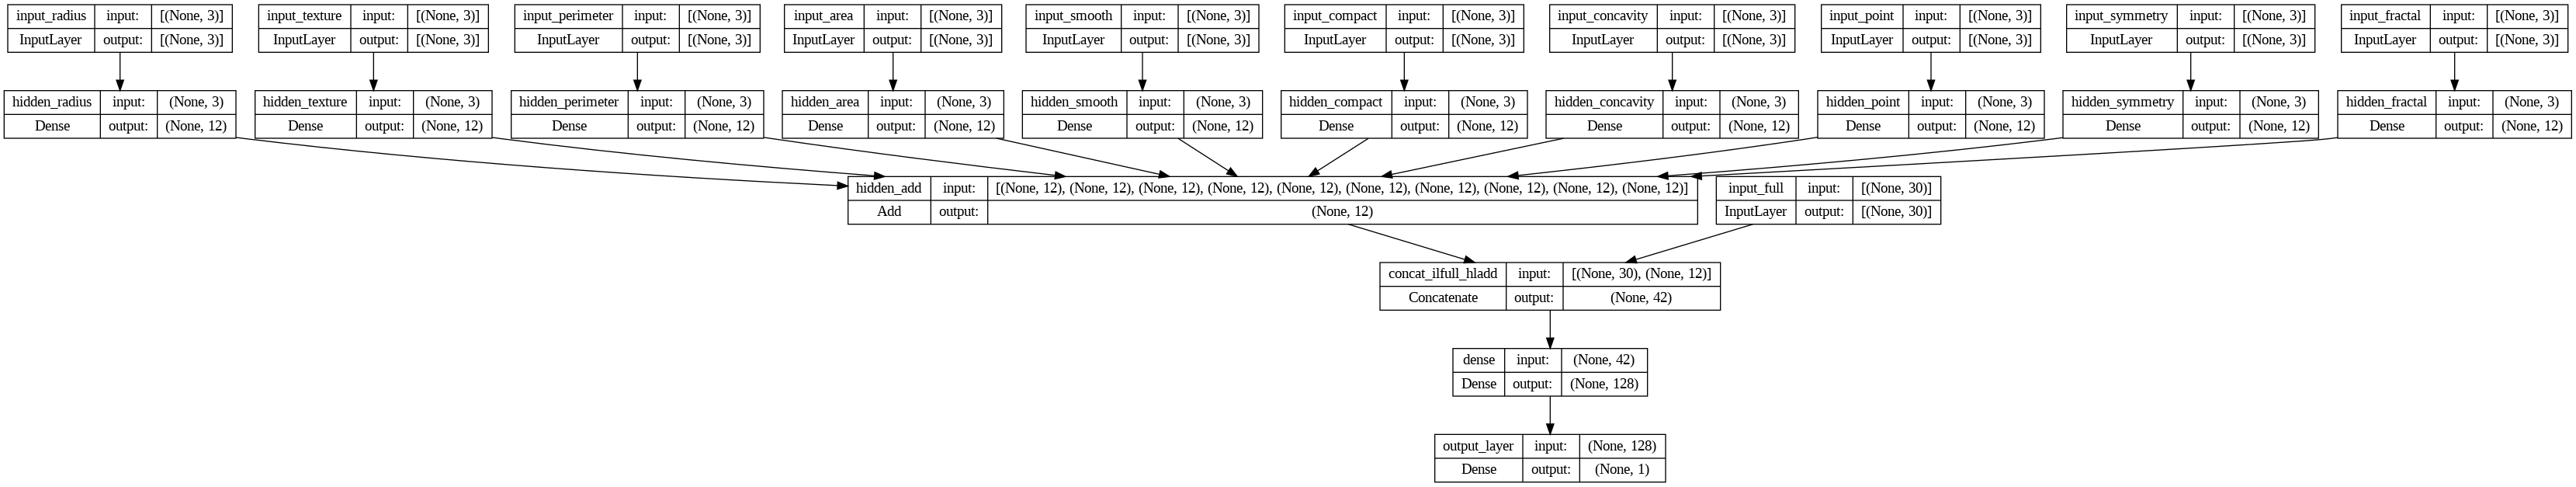

In [27]:
plot_model(model, show_shapes = True)

### 모델 학습

In [29]:
tr_list = [train_x, tr_radius, tr_texture, tr_perimeter, tr_area,
           tr_smoothness, tr_compactness, tr_concavity, tr_con_point,
           tr_symmetry, tr_fractal]
te_list = [test_x, te_radius, te_texture, te_perimeter, te_area,
           te_smoothness, te_compactness, te_concavity, te_con_point,
           te_symmetry, te_fractal]

## 평가

1. 모델의 정확도를 확인하시오.
2. 악성이라 예측한 것 중 실제 악성으로 나온 비율을 구하시오.
3. 실제 악성 중 모델이 악성이라 예측한 것의 비율을 구하시오.
4. 정상이라 예측한 것 중 실제 정상으로 나온 비율을 구하시오.

In [30]:
from tensorflow.keras.callbacks import EarlyStopping
es = EarlyStopping(monitor = "val_loss", min_delta = 0,
                   patience = 5, verbose = 1, restore_best_weights = True)

In [31]:
model.fit(tr_list, train_y, validation_split = 1 / 9,
          verbose = 1, epochs = 1000, callbacks = [es])

Epoch 1/1000
15/15 [==============================] - 9s 33ms/step - loss: 31.7833 - accuracy: 0.5253 - val_loss: 6.8246 - val_accuracy: 0.2456
Epoch 2/1000
15/15 [==============================] - 0s 8ms/step - loss: 3.3034 - accuracy: 0.6923 - val_loss: 1.3152 - val_accuracy: 0.7368
Epoch 3/1000
15/15 [==============================] - 0s 9ms/step - loss: 1.3471 - accuracy: 0.8220 - val_loss: 0.5374 - val_accuracy: 0.8772
Epoch 4/1000
15/15 [==============================] - 0s 9ms/step - loss: 0.7751 - accuracy: 0.8747 - val_loss: 0.0960 - val_accuracy: 0.9649
Epoch 5/1000
15/15 [==============================] - 0s 8ms/step - loss: 0.5146 - accuracy: 0.9033 - val_loss: 0.4049 - val_accuracy: 0.9298
Epoch 6/1000
15/15 [==============================] - 0s 8ms/step - loss: 0.6515 - accuracy: 0.8659 - val_loss: 0.1120 - val_accuracy: 0.9825
Epoch 7/1000
15/15 [==============================] - 0s 8ms/step - loss: 0.4343 - accuracy: 0.8901 - val_loss: 0.1089 - val_accuracy: 0.9649
Epoc

In [32]:
pred_y = model.predict(te_list)
print(pred_y[:11].reshape(-1))
for idx, val in enumerate(pred_y):
    if pred_y[idx] >= 0.5:
        pred_y[idx] = 1
    else:
        pred_y[idx] = 0
print(pred_y[:11].reshape(-1))

2/2 [==============================] - 0s 5ms/step
[9.1147218e-03 4.3268487e-04 3.4339577e-05 6.5702669e-05 4.2728832e-04
 1.3716551e-04 6.4758477e-03 1.0000000e+00 9.8639452e-01 1.0000000e+00
 1.0000000e+00]
[0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1.]


In [40]:
model.evaluate(te_list, test_y)

from sklearn.metrics import classification_report
print(classification_report(test_y, pred_y, target_names = ["Benign", "Malignant"]))

2/2 [==============================] - 0s 7ms/step - loss: 0.3239 - accuracy: 0.9649
              precision    recall  f1-score   support

      Benign       0.94      1.00      0.97        33
   Malignant       1.00      0.92      0.96        24

    accuracy                           0.96        57
   macro avg       0.97      0.96      0.96        57
weighted avg       0.97      0.96      0.96        57



In [ ]:
#정확도 : 96%
#Malignant precision : 100%
#Malignant recall : 92%
#Benign precision : 94%